<a href="https://colab.research.google.com/github/MuHyeonSon/Medical_image_processing/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#인공지능을이용한의료영상처리및실습 Homework #5

바이오메디컬공학부 손무현

다섯 번째 과제의 목표는 MNIST dataset (train:60000 +valid:10000)으로 학습시킨 모델을 이용하여 실습자료03에 포함되어 있는 학생들이 생성한 dataset에 대한 예측정확도를 높이는 것입니다.

 

아래의 Lab08 실습코드를 참고합니다.

https://github.com/hufsaim/T10306201/blob/master/notebook_2021/Lab08_Classification_02.ipynb

 

1. 실습자료03에 포함되어 있는 데이터들은 절대로 모델의 학습(파라미터 업데이트)에 사용되어서는 안됩니다.

 

2. hufs_mnist_inv 폴더에 있는 모든 image (총190개)에 대해 테스트를 진행해 주어야 합니다.

 
3. LeNet의 기본구조는 유지하도록 합니다. CNN model과 관련해서는 새로운 layer의 추가는 불가. 각 layer별로 channel의 개수, neuron의 개수, activation function의 종류, pooling의 종류, learning rate, number of epoch만 변경할 수 있습니다. 

(loss function, backpropagation 관련해서는 본 수업에서는 아직 다루지 않았으므로, loss와 alg은 변경하지 않는 것으로 합니다.)

 

4. training data에 대한 image processing (transform) 은 자유롭게 변경하여도 괜찮습니다. pytorch에서 제공하는 transform을 추가하여도 괜찮고(참고: https://pytorch.org/vision/stable/transforms.html ), 직접 image processing을 적용하여도 괜찮습니다.  

 

5.실습자료03에 포함되어 있는 데이터에 대한 테스트 결과를 요약해주는 confusion matrix를 반드시 포함하여야 합니다. (Lab08 실습코드 참고)

 

6.실습자료03에 포함되어 있는 데이터에 대한 테스트 결과는 Lab08 실습코드를 참고하여 파일명, label, predction을 포함하는 csv파일로 저장합니다.

 

제출하는 파일명은 반드시 HW5_학번.ipynb, HW5_학번.csv로 만들어 제출합니다.

(과제는 팀프로젝트와는 별개로 개인별로 제출합니다.)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
path0 = '/content/drive/MyDrive/Digital_image_processing/HW5/mnist' # replace with your path

모델 학습에 사용할 데이터를 정의

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

transform_train = transforms.Compose(   # *변경가능
    [transforms.ToTensor(),
     transforms.Resize((36,36)),
     transforms.CenterCrop(28),
     #transforms.RandomHorizontalFlip(), # 수평Flip 
     transforms.RandomAffine((-35,35),shear=15, scale=(0.8, 1.2)), #affain transform적용 shear과 sclaing
     #transforms.RandomRotation(45) #random rotation
    ]
    )

mnist_train = torchvision.datasets.MNIST(path0, train=True, transform=transform_train, target_transform=None, download=True)
mnist_valid = torchvision.datasets.MNIST(path0, train=False, transform=transform, target_transform=None, download=True)
def get_mnist_labels(labels):
    text_labels = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']
    return [text_labels[int(i)] for i in labels]

# defining data_iter, linreg. model, loss, sgd
batch_size = 100
num_workers = 0
train_iter = DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers) #traindata에 iteration을 진행할 수 있는 loader를 구성 
valid_iter = DataLoader(mnist_valid, batch_size, shuffle=False, num_workers=num_workers) #

In [ ]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Digital_image_processing/HW5/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(36, 36), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(28, 28))
               RandomAffine(degrees=[-35.0, 35.0], scale=(0.8, 1.2), shear=[-15.0, 15.0])
           )

In [ ]:
mnist_valid

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Digital_image_processing/HW5/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

torch.Size([100])
torch.Size([100, 1, 28, 28])


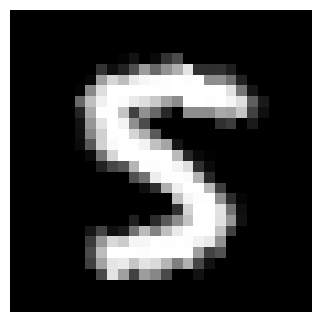

['5']


In [ ]:
#실제로 data를 갖고 있는지 보기 위해 정의한 traindata를 이용해서 하나의 데이터만 갖고 와봄

dataiter=iter(train_iter) # train_iteration은 데이터를 갖고올 때마다 shuffle해가지고 갖고오기 때문에 매번 실행할 때마다 새로운 데이터를 출력함
images, labels = dataiter.next() 
print(labels.shape)
print(images.shape)
I = images[0].numpy()
plt.figure(dpi=100)

plt.imshow(I[0],cmap='gray')
plt.axis('off')
plt.show()
print(get_mnist_labels([labels[0]]))

LeNet 정의
LeNet을 변경해보거나, 다른 architecture를 사용해보기

In [ ]:
net = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), # different  convolution kernels
    nn.ReLU(), # activation function
    nn.AvgPool2d(kernel_size=2, stride=2), #subsampling = pooling (2 by 2 size에 대해서 평균을 취해서 하나를 뽑아 온거임, 그다음 그 2by2가 두 칸 이동하여 같은 작업을 반복하는 것, stride 커지면 아웃풋 사이즈 작아짐, stride줄이면 아웃풋 사이즈 커짐)
    # 2nd conv. layer (같은과정 거침)
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    #vectorize (여러개의 2d array를 하나의 vector로 핌)
    nn.Flatten(),


    #fully connected neural network
    nn.Linear(in_features=16*5*5, out_features=120), #Linear : artificial neuron들을 연결하는 과정 (우리가 vectorize한 neuron들을 120개의 neuron이랑 완전히 연결시키는 것)
    nn.ReLU(),
    nn.Linear(120, 84), # 120개를 84개와 연결
    nn.ReLU(),
    nn.Linear(84, 10) # 10 : number of classes
)
net = net.to(device)
net

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# 각각의 layer에서 size가 어떻게 바뀌는지 *중요*
X = torch.randn(size=(1,1,28,28), dtype = torch.float32)
X = X.to(device)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
ReLU output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
# setting hyper-parameters
learning_rate = 0.03 # parameter를 업데이트할 때 지금 데이터가 어느 정도 비율로 반영할 것인가
num_epochs = 30

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

#모델을 학습시키기

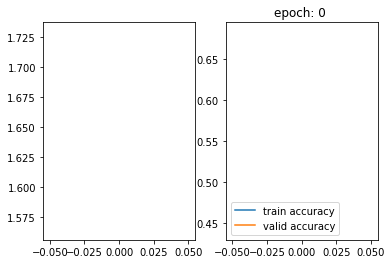

train loss:  1.6464404296875
train accuracy:  0.4422000050544739
valid accuracy:  0.6820999979972839


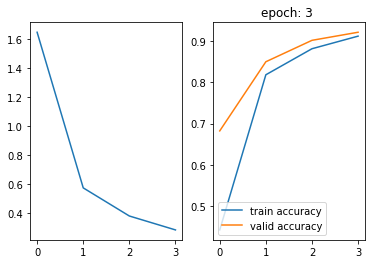

train loss:  0.2851757558186849
train accuracy:  0.911633312702179
valid accuracy:  0.9211000204086304


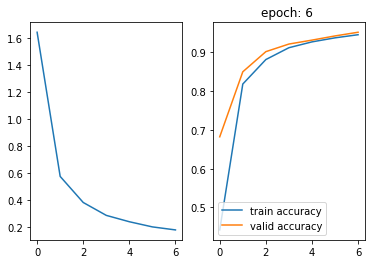

train loss:  0.17713478088378906
train accuracy:  0.9451333284378052
valid accuracy:  0.9514999985694885


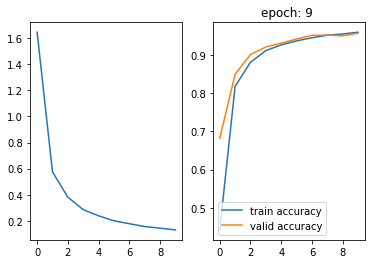

train loss:  0.1295925776163737
train accuracy:  0.9596999883651733
valid accuracy:  0.9574000239372253


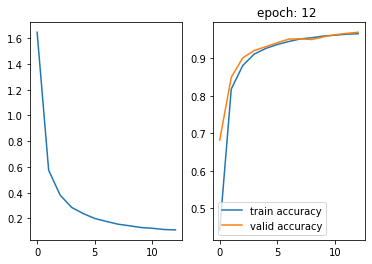

train loss:  0.11077373504638671
train accuracy:  0.9657833576202393
valid accuracy:  0.9697999954223633


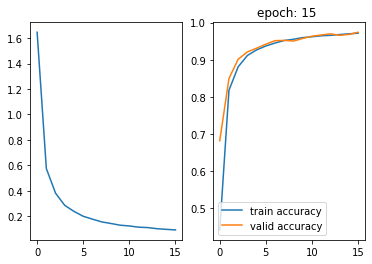

train loss:  0.09242746353149414
train accuracy:  0.9715166687965393
valid accuracy:  0.9740999937057495


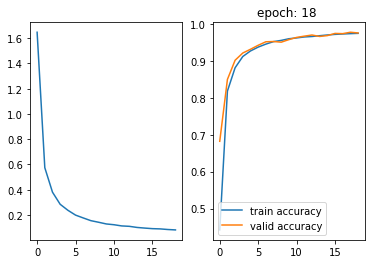

train loss:  0.08239983240763346
train accuracy:  0.9743000268936157
valid accuracy:  0.9753999710083008


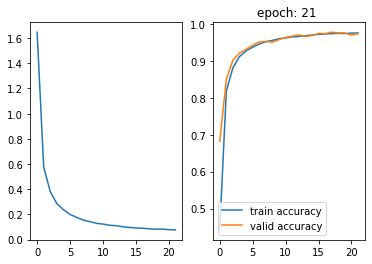

train loss:  0.07711709340413411
train accuracy:  0.9752500057220459
valid accuracy:  0.9736999869346619


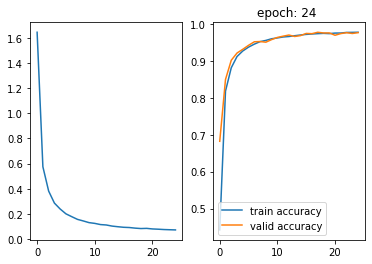

train loss:  0.07145523071289063
train accuracy:  0.9773499965667725
valid accuracy:  0.9761999845504761


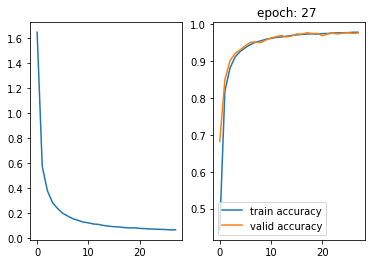

train loss:  0.06788454055786133
train accuracy:  0.9786166548728943
valid accuracy:  0.9764999747276306


In [ ]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:        # training data에 대한 루프
    i=i+1  #X : image(input), y: label (0,1,2,3,4,5,6,7,8,9)
    X,y = X.to(device),y.to(device) # GPU 
    y_hat=net(X) #forward calculation (X라고 하는 이미지를 네트워크에 넣어서 출력을 받는 것) -> y_hat:10 x 1 vector (10개의 숫자를 가지는 벡터가 나옴)
    correct += (y_hat.argmax(dim=1)==y).sum() 
    l=loss(y_hat,y) # output & label -> loss를 계산
    l_epoch+=l
    alg.zero_grad()
    l.backward() # loss를 바탕으로 backpropagation 하는 거임
    alg.step() # parameter update

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/60000.)

  correct = 0
  # validation set
  for X,y in valid_iter:        # validation data에 대한 루프
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum() # 여기서는 정확도만을 체크하고 backpropagation을 진행하지 않음(backword 연산 진행X)
    # parameter update 진행 X # validation set은 parameter를 업데이트 하는데 사용되지 않은 데이터에 대해서
     # 얼마나 좋은 정확도를 보여줄 수 있는 가를 판별하기 위한 데이터이기 때문
     
  accs_valid = np.append(accs_valid,correct.cpu()/10000.)


  if epoch%3 == 0:
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.show()

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

Validation Set에 대한 결과를 이미지로 관찰하기

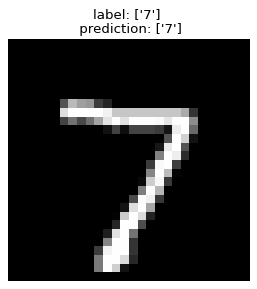

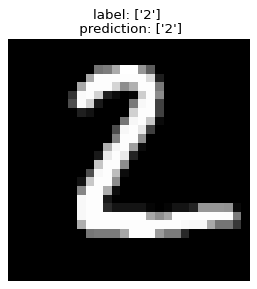

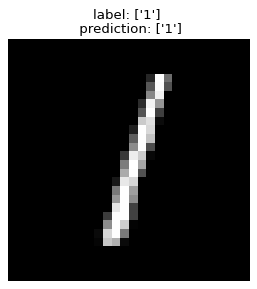

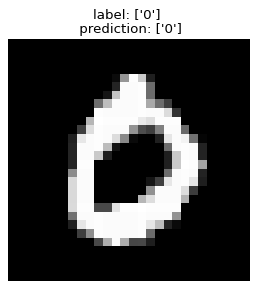

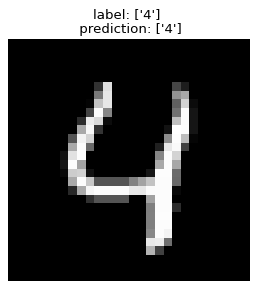

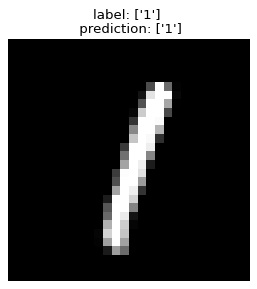

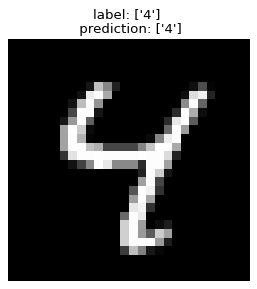

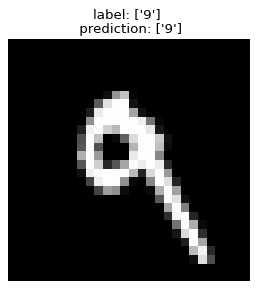

In [ ]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(8):
    plt.figure(dpi=80)
    plt.imshow(X[n].cpu().squeeze(),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(get_mnist_labels([y[n]]),get_mnist_labels([y_hat[n]])))
    plt.axis('off')
    plt.show()
  break

직접 만든 데이터에 테스트해보기

In [ ]:
import glob
import os
from PIL import Image
import pandas as pd

In [ ]:
flist = sorted(glob.glob(os.path.join(path0,'hufs_mnist/hufs_mnist_inv/*.png')))
flist[:4]

['/content/drive/MyDrive/Digital_image_processing/HW5/mnist/hufs_mnist/hufs_mnist_inv/l_001_00.png',
 '/content/drive/MyDrive/Digital_image_processing/HW5/mnist/hufs_mnist/hufs_mnist_inv/l_001_01.png',
 '/content/drive/MyDrive/Digital_image_processing/HW5/mnist/hufs_mnist/hufs_mnist_inv/l_001_02.png',
 '/content/drive/MyDrive/Digital_image_processing/HW5/mnist/hufs_mnist/hufs_mnist_inv/l_001_03.png']

/content/drive/MyDrive/Digital_image_processing/HW5/mnist/hufs_mnist/hufs_mnist_inv/l_006_09.png


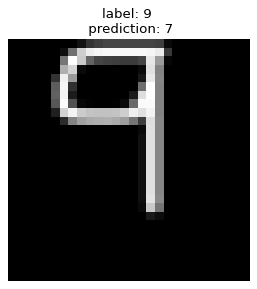

In [ ]:
#데이터를 하나 불러와서 모델에다 넣어서 예측결과를 얻어보기

n=39
print(flist[n])
I = Image.open(flist[n])
I = I.resize((28,28))
I = (I - np.min(I))/(np.max(I)-np.min(I))
X = torch.zeros((1,1,28,28))
X[0,0] = torch.tensor(I)
y_hat=net(X.to(device))
#print(y_hat)
y_hat = y_hat.argmax(dim=1)
label = int(flist[n].split('.png')[0].split('_')[-1])
prediction = int(get_mnist_labels([y_hat])[0])
plt.figure(dpi=80)
plt.imshow(X[0,0].cpu().squeeze(),cmap='gray')
plt.title('label: %s \n prediction: %s'%(label,prediction))
plt.axis('off')
plt.show()

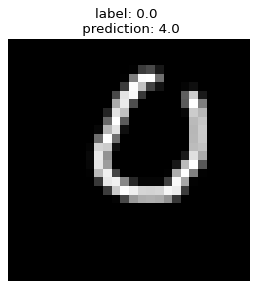

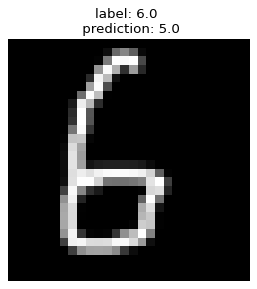

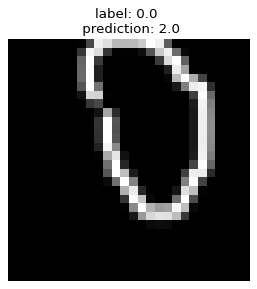

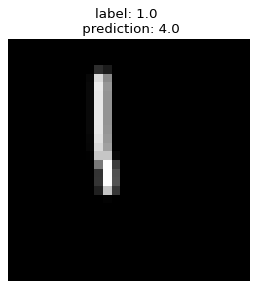

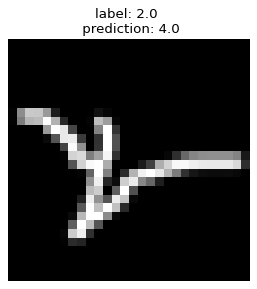

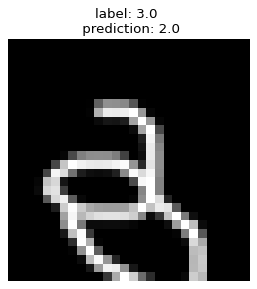

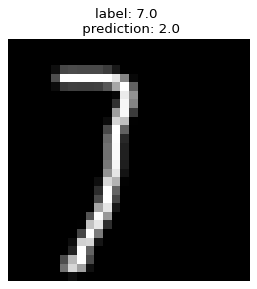

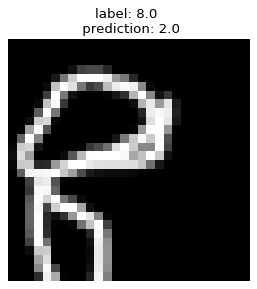

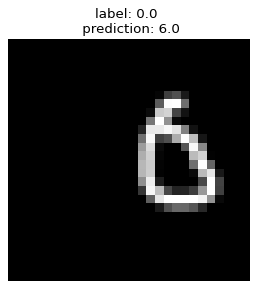

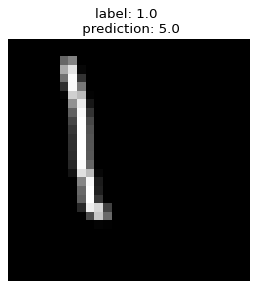

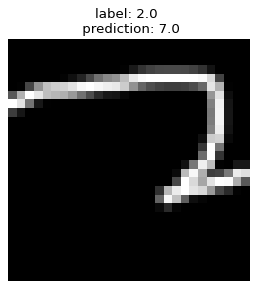

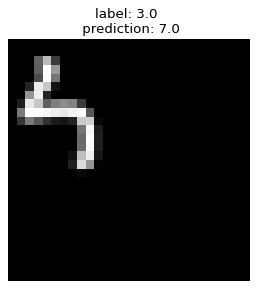

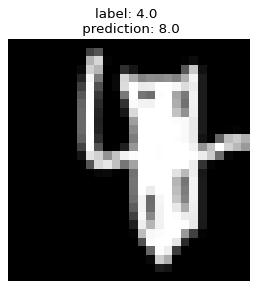

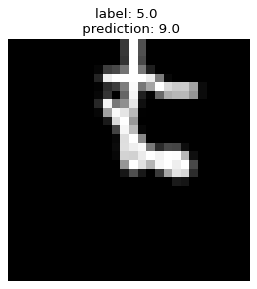

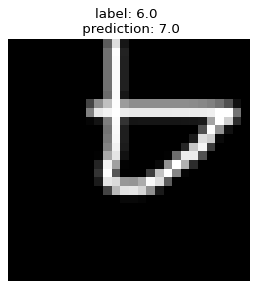

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


test accuracy = 44.21052631578947%


In [ ]:
# 전체 데이터에 대해서 돌려본 것 (틀린 케이스에 대해서만 출력)

cnt=0
N_correct = 0
N_incorrect = 0
results = np.zeros((2,len(flist)))

for fn in flist:
    I = Image.open(fn)
    I = I.resize((28,28)) # 이미지프로세싱(resize)
    I = (I - np.min(I))/(np.max(I)-np.min(I)) #이미지프로세싱(intensity standardization[0,1])
    X = torch.zeros((1,1,28,28))
    X[0,0] = torch.tensor(I)
    y_hat=net(X.to(device))
  #print(y_hat)
    y_hat = y_hat.argmax(dim=1)
    results[0,cnt] = int(fn.split('.png')[0].split('_')[-1])
    results[1,cnt] = int(get_mnist_labels([y_hat])[0])

    if not(results[0,cnt]==results[1,cnt]):
        N_incorrect = N_incorrect + 1
        if N_incorrect<16:
            plt.figure(dpi=80)
            plt.imshow(X[0,0].cpu().squeeze(),cmap='gray')
            plt.title('label: %s \n prediction: %s'%(results[0,cnt],results[1,cnt]))
            plt.axis('off')
            plt.show()
    else:
        N_correct = N_correct + 1

    cnt=cnt+1

print(f'test accuracy = {100*(N_correct)/len(flist)}%',)

In [ ]:
T = pd.DataFrame({'filename':flist,'label':results[0,:],'prediction':results[1,:]})
T.to_csv(os.path.join(path0,'HW5_201804594.csv'))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

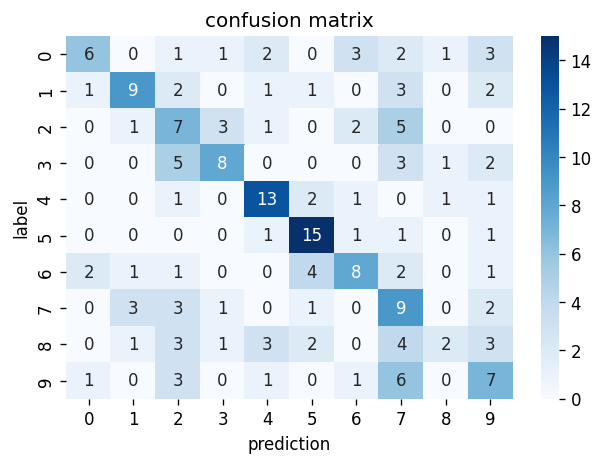

In [ ]:
cf = confusion_matrix(results[0,:],results[1,:])
plt.figure(dpi=120)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.title('confusion matrix')
plt.ylabel('label')
plt.xlabel('prediction')
plt.show()